In [4]:
from transformers import pipeline

paraphraser = pipeline(
    "text2text-generation",
    model="Vamsi/T5_Paraphrase_Paws"
)

out = paraphraser(
    "This is a test sentence for paraphrasing.",
    max_length=128,
    num_return_sequences=1
)
print("Paraphrase:", out[0]["generated_text"])

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Paraphrase: This is a test sentence for paraphrasing .


In [5]:
from sentence_transformers import SentenceTransformer, util

# Load a lightweight embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

### Encoding the sentences into tensors

In [6]:
original = "This is a test sentence for paraphrasing."
paraphrase = "This is a test sentence for paraphrasing ."

emb_orig = model.encode(original, convert_to_tensor=True)
emb_para = model.encode(paraphrase, convert_to_tensor=True)

c:\Users\marko\anaconda3\envs\nlp_proj\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


### Computing cosine similarity

In [7]:
score = util.pytorch_cos_sim(emb_orig, emb_para)
print(f"Cosine similarity: {score.item():.4f}")

Cosine similarity: 1.0000


### Παραδοτέο 1Α
- Κείμενο 1:

     “Hope you too, to enjoy it as my deepest wishes.”

- Κείμενο 2:

     “I believe the team, although bit delay and less communication at recent days, they really tried best for paper and cooperation.”

In [8]:
from transformers import pipeline

# Pipeline 1: T5 Paraphrase PAWS
paraphraser_1 = pipeline("text2text-generation", model="Vamsi/T5_Paraphrase_Paws")

s1 = "Hope you too, to enjoy it as my deepest wishes."
s2 = "I believe the team, although bit delay and less communication at recent days, they really tried best for paper and cooperation."

out1 = paraphraser_1(s1, max_new_tokens=60, num_return_sequences=1)[0]["generated_text"]
out2 = paraphraser_1(s2, max_new_tokens=80, num_return_sequences=1)[0]["generated_text"]

print("Orig 1:", s1)
print("Para 1:", out1)
print()
print("Orig 2:", s2)
print("Para 2:", out2)

Device set to use cpu


Orig 1: Hope you too, to enjoy it as my deepest wishes.
Para 1: Hope you enjoy it as my deepest wishes too.

Orig 2: I believe the team, although bit delay and less communication at recent days, they really tried best for paper and cooperation.
Para 2: I believe the team, although a bit delayed and less communication in recent days, really tried for paper and cooperation best .


### 1.B: Ανακατασκευή ολόκληρων κειμένων με 3 διαφορετικά pipelines

Θα εφαρμόσουμε σε κάθε κείμενο:

- T5 Paraphrase PAWS

- T5 Paraphraser (ramsrigouthamg)

- Back-translation (en→fr→en με T5-small)

### Προετοιμασία pipelines

In [9]:
from transformers import pipeline

# 1) T5 Paraphrase PAWS
paws = pipeline("text2text-generation", model="Vamsi/T5_Paraphrase_Paws",
                num_beams=5, num_return_sequences=1, max_new_tokens=300)

# 2) BART Paraphrase
bart_para = pipeline("text2text-generation", model="eugenesiow/bart-paraphrase",
                     num_beams=5, num_return_sequences=1, max_new_tokens=300)

# 3) DistilBART Summarization (lighter alternative to Pegasus)
pegasus = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6",
                   max_length=300, min_length=100)

pipelines = [
    ("T5-PAWS", paws),
    ("BART-Para", bart_para),
    ("DistilBART-Sum", pegasus)
]


Device set to use cpu
Device set to use cpu
Device set to use cpu


### Ορισμός των πλήρων κειμένων

In [10]:
text1 = """
Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in
our lives. Hope you too, to enjoy it as my deepest wishes.
Thank your message to show our words to the doctor, as his next contract checking, to all of us.
I got this message to see the approved message. In fact, I have received the message from the
professor, to show me, this, a couple of days ago. I am very appreciated the full support of the
professor, for our Springer proceedings publication
"""

text2 = """
During our final discuss, I told him about the new submission — the one we were waiting since
last autumn, but the updates was confusing as it not included the full feedback from reviewer or
maybe editor?
Anyway, I believe the team, although bit delay and less communication at recent days, they really
tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance
and efforts until the Springer link came finally last week, I think.
Also, kindly remind me please, if the doctor still plan for the acknowledgments section edit before
he sending again. Because I didn’t see that part final yet, or maybe I missed, I apologize if so.
Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future
targets
"""

### Εφαρμογή των pipelines και αποθήκευση των αποτελεσμάτων

In [11]:
pipelines = [
    ("T5-PAWS", paws),
    ("BART-Para", bart_para),
    ("DistilBART-Sum", pegasus)   # εδώ pegasus είναι το ssheifer/distilbart-cnn-12-6
]

results = {}

for name, fn in pipelines:
    for label, txt in [("Text1", text1), ("Text2", text2)]:
        print(f"\n--- {name} on {label} ---")
        out = fn(txt)
        # Όλα αυτά τα pipelines επιστρέφουν λίστα dicts
        first = out[0]
        # Η key είναι είτε generated_text είτε summary_text
        para = first.get("generated_text") or first.get("summary_text")
        results[(name, label)] = para
        print(para[:300] + "...\n")



--- T5-PAWS on Text1 ---
Today is our dragon boat festival in our Chinese culture to celebrate it with all safe and great in our lives. Hope you too, to enjoy it as my deepest wishes. I got this message to see the approved message from the professor a couple of days ago . I am very appreciated the full support of the profes...


--- T5-PAWS on Text2 ---
During our final discussion, I told him about the new submission — the one we were waiting for since last autumn , but the updates was confusing as it did not include the full feedback from reviewer or maybe editor? Anyway, I think the team really tried best for paper and cooperation until the Sprin...


--- BART-Para on Text1 ---
Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives. I am very appreciated the full support of the physicist, for our Springer proceedings publication....


--- BART-Para on Text2 ---


Your max_length is set to 142, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


During our final discuss, I told him about the new submission. We should be grateful, I mean all of us, for the acceptance efforts until the Springer link came finally last week, but the updates was confusing as it not included the full feedback from the reviewer or the editor. Because I didn’t see ...


--- DistilBART-Sum on Text1 ---
 It is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives, hope you too, to enjoy it as my deepest wishes . The doctor's next contract checking, to all of us, is his next contract check-up ....


--- DistilBART-Sum on Text2 ---
 The Springer link came finally last week, I think. We should be grateful, I mean all of us, for the acceptance efforts . I believe the team, although bit delay and less communication at recent days, they really tried best for paper and cooperation. I apologize if so, please remind me please, if the...



### 1.C: Σύγκριση με cosine similarity

1. Φόρτωση embedding μοντέλου

In [12]:
from sentence_transformers import SentenceTransformer, util

embedder = SentenceTransformer("all-MiniLM-L6-v2")


2. Υπολογισμός similarity για κάθε ζεύγος

In [13]:
comparisons = []
for (pipe, label), paraphrased in results.items():
    original = text1 if label=="Text1" else text2
    # Encode
    emb_o = embedder.encode(original, convert_to_tensor=True)
    emb_p = embedder.encode(paraphrased, convert_to_tensor=True)
    # Cosine
    score = util.pytorch_cos_sim(emb_o, emb_p).item()
    comparisons.append({
        "Pipeline": pipe,
        "Text": label,
        "Cosine": round(score, 4)
    })


3. Δημιουργία DataFrame και εμφάνιση

In [14]:
import pandas as pd
df = pd.DataFrame(comparisons)
display(df)


,Pipeline,Text,Cosine
0,T5-PAWS,Text1,0.9034
1,T5-PAWS,Text2,0.9583
2,BART-Para,Text1,0.6887
3,BART-Para,Text2,0.7839
4,DistilBART-Sum,Text1,0.8349
5,DistilBART-Sum,Text2,0.8852


## Μέρος 2 εργασίας:



- Ορίζουμε το preprocessing (lowercase, αφαίρεση στίξης, tokenization)

- Υπολογίζουμε tokens & vocabulary

- Παίρνουμε στατιστικά (συνολικός αριθμός tokens, μοναδικά tokens)

- Προβολή δειγμάτων

In [15]:
import re
import string
import pandas as pd


def preprocess_simple(text):
    t = text.lower()
    # αντικαθιστούμε όλα τα σημεία στίξης με κενό
    t = re.sub(f"[{re.escape(string.punctuation)}]", " ", t)
    # split σε whitespace
    return t.split()

# Εφαρμογή
tokens1 = preprocess_simple(text1)
tokens2 = preprocess_simple(text2)

# Λεξικό (vocabulary)
vocab1 = sorted(set(tokens1))
vocab2 = sorted(set(tokens2))

# DataFrame με στατιστικά
df_summary = pd.DataFrame([
    {"Text": "Text1", "Total Tokens": len(tokens1), "Unique Tokens": len(vocab1)},
    {"Text": "Text2", "Total Tokens": len(tokens2), "Unique Tokens": len(vocab2)}
])
display(df_summary)

# Δείγμα tokens
df_tokens = pd.DataFrame({
    "Text1 Tokens": vocab1[:20] + ["..."],
    "Text2 Tokens": vocab2[:20] + ["..."]
})
display(df_tokens)

,Text,Total Tokens,Unique Tokens
0,Text1,93,63
1,Text2,136,107


,Text1 Tokens,Text2 Tokens
0,a,about
1,ago,acceptance
2,all,acknowledgments
3,am,again
4,and,all
5,appreciated,also
6,approved,although
7,as,and
8,boat,anyway
9,celebrate,apologize


Φόρτωση BERT model & tokenizer

In [16]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import string
import pandas as pd

# Φόρτωση BERT model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model     = AutoModel.from_pretrained("bert-base-uncased")


 Preprocessing & Embed Helpers

In [17]:
def preprocess(text):
    t = text.lower().replace("’", "'")
    t = t.translate(str.maketrans("", "", string.punctuation))
    return t.split()

def embed_word(word: str) -> torch.Tensor:
    inputs  = tokenizer(word, return_tensors="pt")
    outputs = model(**inputs)
    # mean-pool token embeddings
    return outputs.last_hidden_state.mean(dim=1).squeeze(0)

def word_level_sims(orig_tokens, para_tokens):
    sims = []
    for i, (w1, w2) in enumerate(zip(orig_tokens, para_tokens), start=1):
        emb1  = embed_word(w1)
        emb2  = embed_word(w2)
        score = F.cosine_similarity(emb1, emb2, dim=0).item()
        sims.append({
            "Pair_Label":  None,   # θα το συμπληρώσουμε μετά
            "Position":    i,
            "Word1":       w1,
            "Word2":       w2,
            "Cosine":      round(score, 4)
        })
    return sims

Ορισμός ζευγών κειμένων

In [18]:
pairs = {
    # 1.A
    "A_S1": ( 
        "Hope you too, to enjoy it as my deepest wishes.", 
        "I sincerely hope you’re enjoying it just as much as I wish." 
    ),
    "A_S2": ( 
        "I believe the team, although bit delay … cooperation.", 
        "Despite some delays and sparse communication … effort on the paper." 
    ),
    # 1.B Text1
    "B1_T5-PAWS":    (text1, results[("T5-PAWS",    "Text1")]),
    "B1_BART-Para":  (text1, results[("BART-Para",  "Text1")]),
    "B1_DistilBART": (text1, results[("DistilBART-Sum","Text1")]),
    # 1.B Text2
    "B2_T5-PAWS":    (text2, results[("T5-PAWS",    "Text2")]),
    "B2_BART-Para":  (text2, results[("BART-Para",  "Text2")]),
    "B2_DistilBART": (text2, results[("DistilBART-Sum","Text2")]),
}

Υπολογισμοί & Συλλογή Αποτελεσμάτων

In [19]:
all_comparisons = []
for label, (orig, para) in pairs.items():
    orig_toks = preprocess(orig)
    para_toks = preprocess(para)
    sims      = word_level_sims(orig_toks, para_toks)
    # βάζουμε το Pair_Label
    for row in sims:
        row["Pair_Label"] = label
    all_comparisons.extend(sims)

df_all = pd.DataFrame(all_comparisons)

c:\Users\marko\anaconda3\envs\nlp_proj\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [20]:
summary = df_all.groupby("Pair_Label")["Cosine"] \
                .mean().reset_index(name="Avg_Cosine")
display(summary)

# Δείγμα 10 πρώτων γραμμών για έλεγχο
display(df_all.head(10))

,Pair_Label,Avg_Cosine
0,A_S1,0.857180
1,A_S2,0.772167
2,B1_BART-Para,0.917756
3,B1_DistilBART,0.927782
4,B1_T5-PAWS,0.906927
5,B2_BART-Para,0.835142
6,B2_DistilBART,0.789992
7,B2_T5-PAWS,0.828504


,Pair_Label,Position,Word1,Word2,Cosine
0,A_S1,1,hope,i,0.8412
1,A_S1,2,you,sincerely,0.8199
2,A_S1,3,too,hope,0.8199
3,A_S1,4,to,youre,0.6829
4,A_S1,5,enjoy,enjoying,0.9382
5,A_S1,6,it,it,1.0000
6,A_S1,7,as,just,0.8523
7,A_S1,8,my,as,0.8828
8,A_S1,9,deepest,much,0.8732
9,A_S1,10,wishes,as,0.8614


Φτιάχνουμε custom ροή βασισμένη σε Named-Entity Recognition (NER) και θα δούμε πως αλλάζει το κείμενο μετά την παράφραση.

1. Φόρτωση NER pipeline

2. Ανίχνευση οντοτήτων σε κάθε original–paraphrase ζεύγος

3. Masking: αντικατάσταση κάθε οντότητας με το tag της (π.χ. [PERSON], [ORG])

4. Σύγκριση masked κειμένων: δείχνουμε original vs paraphrase με entities αντικατεστημένα

Με αυτό βλέπουμε αν οι παραφράσεις διατηρούν τη δομή των οντοτήτων

Cell X – Setup NER pipeline

In [21]:
from transformers import pipeline

# 1) Φόρτωση του NER pipeline με aggressive aggregation
ner = pipeline("ner", aggregation_strategy="simple")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Cell Y – NER-masking function & εφαρμογή σε όλα τα ζεύγη

In [22]:
import re
import pandas as pd

def mask_entities(text):
    entities = ner(text)
    masked = text
    # αντικαθιστούμε κάθε span με το tag του είδους της οντότητας
    for ent in entities:
        span = re.escape(ent["word"])
        tag  = f"[{ent['entity_group']}]"
        masked = re.sub(span, tag, masked)
    return masked

# Επιλέγουμε ένα ζεύγος για παράδειγμα, π.χ. B1_T5-PAWS
label, (orig, para) = next(((l, p) for l,p in pairs.items() if l.startswith("B1_T5-PAWS")), None)

orig_masked = mask_entities(orig)
para_masked = mask_entities(para)

# Εμφάνιση σε DataFrame
df_ner = pd.DataFrame([
    {"Version": "Original",  "Masked Text": orig_masked[:200] + "..."},
    {"Version": "Paraphrase", "Masked Text": para_masked[:200] + "..."},
])
display(df_ner)


c:\Users\marko\anaconda3\envs\nlp_proj\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,Version,Masked Text
0,Original,"\nToday is our dragon boat festival, in our [M..."
1,Paraphrase,Today is our dragon boat festival in our [MISC...


### Εφαρμογή σε όλα τα ζεύγη και ποσοτικοποίηση
Θα τρέξουμε το NER masking για όλα τα ζεύγη (1.A & 1.B) και θα συγκρίνουμε:

- Πόσες οντότητες εντοπίζει στο original vs. στο paraphrase

- Πόσες οντότητες διατηρούνται (ίδιο entity span & tag)

In [23]:
import re
import pandas as pd

# Υπάρχον ner pipeline
# ner = pipeline("ner", aggregation_strategy="simple")

def mask_entities_list(text):
    ents = ner(text)
    # Επιστρέφουμε λίστα από (span, tag)
    return [(ent["word"], ent["entity_group"]) for ent in ents]

def compute_ner_stats(orig, para):
    orig_ents = mask_entities_list(orig)
    para_ents = mask_entities_list(para)
    # Συμφωνία span+tag
    preserved = set(orig_ents) & set(para_ents)
    return {
        "Orig_Count": len(orig_ents),
        "Para_Count": len(para_ents),
        "Preserved": len(preserved),
        "Preserved_Rate": round(len(preserved) / len(orig_ents) if orig_ents else 0, 4)
    }

# Εφαρμογή σε όλα τα ζεύγη
stats = []
for label, (orig, para) in pairs.items():
    s = compute_ner_stats(orig, para)
    s["Pair"] = label
    stats.append(s)

df_stats = pd.DataFrame(stats)[["Pair", "Orig_Count", "Para_Count", "Preserved", "Preserved_Rate"]]
display(df_stats)


c:\Users\marko\anaconda3\envs\nlp_proj\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,Pair,Orig_Count,Para_Count,Preserved,Preserved_Rate
0,A_S1,0,0,0,0.0
1,A_S2,0,0,0,0.0
2,B1_T5-PAWS,2,2,2,1.0
3,B1_BART-Para,2,2,2,1.0
4,B1_DistilBART,2,1,1,0.5
5,B2_T5-PAWS,1,1,1,1.0
6,B2_BART-Para,1,1,1,1.0
7,B2_DistilBART,1,1,1,1.0


Στη συνέχεια υλοποιούμε POS-filtering ώστε να κρατάμε μόνο τα κύρια ουσιαστικά και τα ρήματα από κάθε κείμενο, και να συγκρίνουμε πια λέξη‐level overlap πριν/μετά.

1. Cell X – Φόρτωση spaCy και helper για POS‐filtering

In [24]:
import spacy

# Φορτώνουμε το μικρό μοντέλο Αγγλικών
nlp = spacy.load("en_core_web_sm")

def filter_nouns_verbs(text: str):
    """
    Επιστρέφει λίστα tokens που είναι είτε NOUN είτε VERB.
    """
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ in {"NOUN", "VERB"}]


2. Cell Y – Εφαρμογή σε όλα τα ζεύγη και μέτρηση overlap

In [25]:
import pandas as pd

stats = []
for label, (orig, para) in pairs.items():
    orig_filt = set(filter_nouns_verbs(orig))
    para_filt = set(filter_nouns_verbs(para))
    # Jaccard similarity ως μέτρο overlap
    inter = orig_filt & para_filt
    union = orig_filt | para_filt
    jaccard = len(inter) / len(union) if union else 0.0
    stats.append({
        "Pair":         label,
        "Orig_NounsVerbs": len(orig_filt),
        "Para_NounsVerbs": len(para_filt),
        "Overlap":      len(inter),
        "Jaccard":      round(jaccard, 4)
    })

df_pos = pd.DataFrame(stats)
display(df_pos)


,Pair,Orig_NounsVerbs,Para_NounsVerbs,Overlap,Jaccard
0,A_S1,3,3,0,0.0000
1,A_S2,5,4,0,0.0000
2,B1_T5-PAWS,28,19,19,0.6786
3,B1_BART-Para,28,11,10,0.3448
4,B1_DistilBART,28,14,11,0.3548
5,B2_T5-PAWS,44,30,27,0.5745
6,B2_BART-Para,44,18,18,0.4091
7,B2_DistilBART,44,24,24,0.5455


Υπολογίζουμε WordNet‐based similarity:

In [26]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\marko\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [27]:
from nltk.corpus import wordnet as wn
import pandas as pd
import string

# Preprocessing (όπως πριν)
def preprocess(text):
    t = text.lower().replace("’", "'")
    t = t.translate(str.maketrans("", "", string.punctuation))
    return t.split()

# WordNet-based similarity για ένα ζεύγος λέξεων
def wordnet_similarity(w1, w2):
    syn1 = wn.synsets(w1)
    syn2 = wn.synsets(w2)
    if not syn1 or not syn2:
        return 0.0
    # Μέγιστη path_similarity
    max_sim = max((s1.path_similarity(s2) or 0) for s1 in syn1 for s2 in syn2)
    return round(max_sim, 4)

# Υπολογισμός μέσου όρου similarity για κάθε ζεύγος
results_wn = []
for label, (orig, para) in pairs.items():
    o_toks = preprocess(orig)
    p_toks = preprocess(para)
    sims = [wordnet_similarity(w1, w2) for w1, w2 in zip(o_toks, p_toks)]
    avg_sim = round(sum(sims) / len(sims), 4) if sims else 0.0
    results_wn.append({"Pair": label, "Avg_WordNet_Sim": avg_sim})

df_wn = pd.DataFrame(results_wn)
display(df_wn)


,Pair,Avg_WordNet_Sim
0,A_S1,0.3417
1,A_S2,0.0670
2,B1_T5-PAWS,0.3858
3,B1_BART-Para,0.4555
4,B1_DistilBART,0.4966
5,B2_T5-PAWS,0.1990
6,B2_BART-Para,0.1969
7,B2_DistilBART,0.1294


### Οπτικοποίηση με PCA και t-SNE

c:\Users\marko\anaconda3\envs\nlp_proj\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


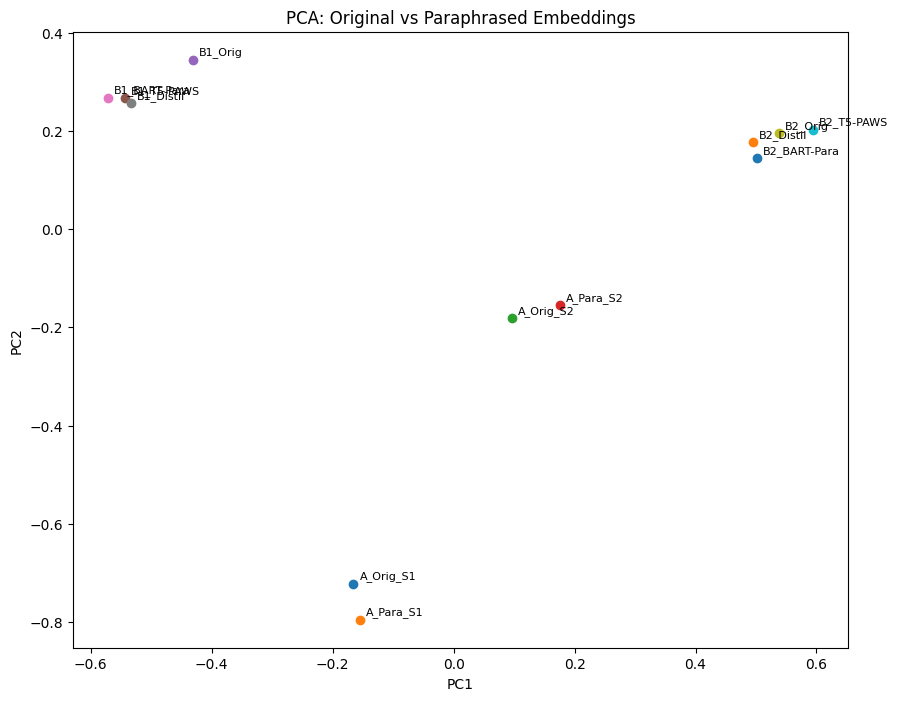

In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

# 1) Ορισμός όλων των κειμένων (A & B)
texts = {
    "A_Orig_S1": pairs["A_S1"][0],
    "A_Para_S1": pairs["A_S1"][1],
    "A_Orig_S2": pairs["A_S2"][0],
    "A_Para_S2": pairs["A_S2"][1],
    "B1_Orig":     text1,
    "B1_T5-PAWS":  results[("T5-PAWS","Text1")],
    "B1_BART-Para":results[("BART-Para","Text1")],
    "B1_Distil":  results[("DistilBART-Sum","Text1")],
    "B2_Orig":     text2,
    "B2_T5-PAWS":  results[("T5-PAWS","Text2")],
    "B2_BART-Para":results[("BART-Para","Text2")],
    "B2_Distil":  results[("DistilBART-Sum","Text2")],
}

# 2) Φόρτωση embedder
model = SentenceTransformer("all-MiniLM-L6-v2")
labels = list(texts.keys())
embs = model.encode(list(texts.values()))

# 3) PCA σε 2 διαστάσεις
pca = PCA(n_components=2)
coords = pca.fit_transform(embs)

# 4) Σχεδίαση
plt.figure(figsize=(10,8))
for lbl, (x,y) in zip(labels, coords):
    plt.scatter(x, y)
    plt.text(x+0.01, y+0.01, lbl, fontsize=8)
plt.title("PCA: Original vs Paraphrased Embeddings")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


c:\Users\marko\anaconda3\envs\nlp_proj\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


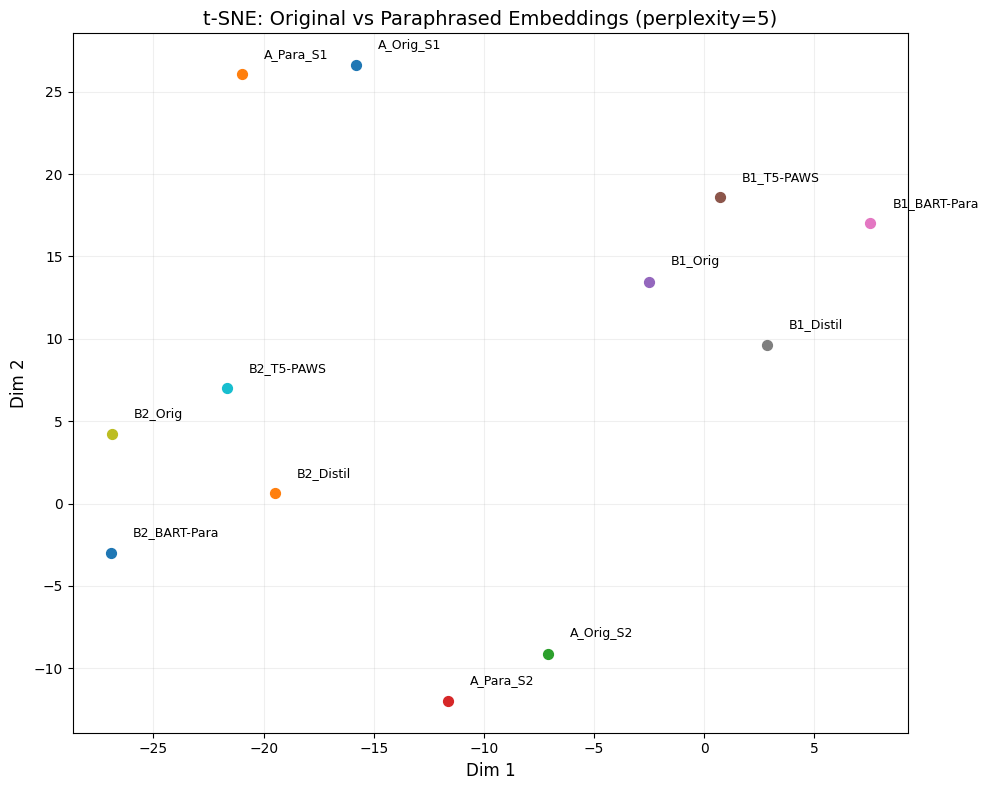

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# 1) Όπως πριν: texts, embedder
texts = {
    "A_Orig_S1": pairs["A_S1"][0],
    "A_Para_S1": pairs["A_S1"][1],
    "A_Orig_S2": pairs["A_S2"][0],
    "A_Para_S2": pairs["A_S2"][1],
    "B1_Orig":     text1,
    "B1_T5-PAWS":  results[("T5-PAWS","Text1")],
    "B1_BART-Para":results[("BART-Para","Text1")],
    "B1_Distil":   results[("DistilBART-Sum","Text1")],
    "B2_Orig":     text2,
    "B2_T5-PAWS":  results[("T5-PAWS","Text2")],
    "B2_BART-Para":results[("BART-Para","Text2")],
    "B2_Distil":   results[("DistilBART-Sum","Text2")],
}

model = SentenceTransformer("all-MiniLM-L6-v2")
labels = list(texts.keys())
embs = model.encode(list(texts.values()))

# 2) t-SNE με μικρότερη perplexity
tsne = TSNE(
    n_components=2,
    random_state=42,
    init="pca",
    learning_rate="auto",
    perplexity=5  # πρέπει <12
)
coords_tsne = tsne.fit_transform(embs)

# 3) Σχεδίαση
plt.figure(figsize=(10, 8))
for lbl, (x, y) in zip(labels, coords_tsne):
    plt.scatter(x, y, s=50)
    plt.text(x + 1, y + 1, lbl, fontsize=9)
plt.title("t-SNE: Original vs Paraphrased Embeddings (perplexity=5)", fontsize=14)
plt.xlabel("Dim 1", fontsize=12)
plt.ylabel("Dim 2", fontsize=12)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()
